In [8]:
%load_ext autoreload
%autoreload 2

# Setup Environment
import sys
import os
ROOT = '../../'
sys.path.append(ROOT)

import gym
from gym.spaces import Discrete
import numpy as np
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from source.agents.sarsa_agnet import SarsaAgent
from source.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


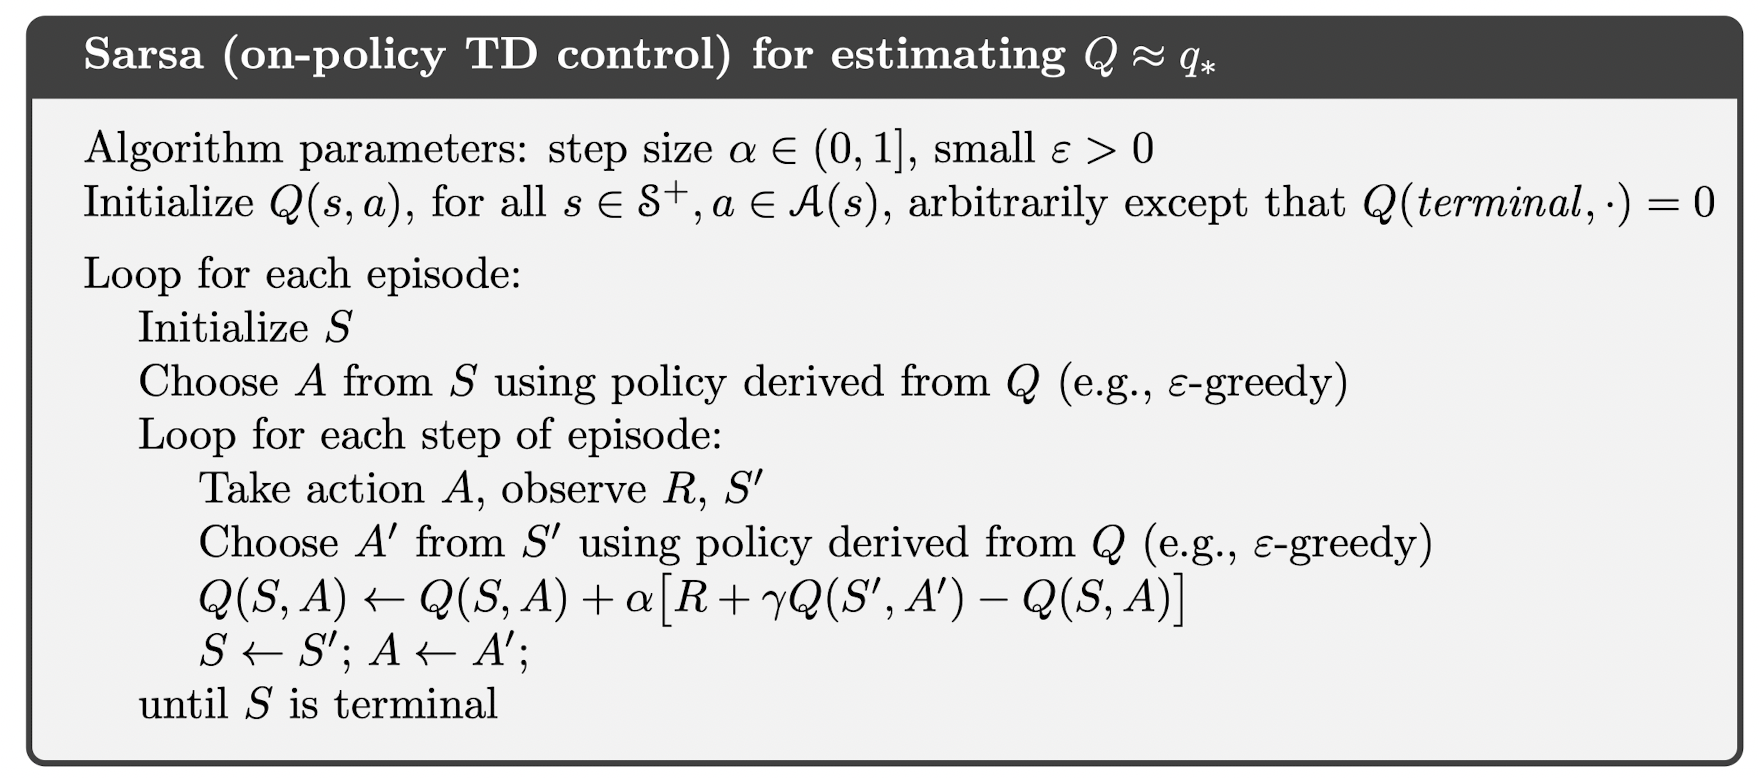

step: 1000, epsilon: 0.65230169730996, total reward: 3.0, avarge success rate: 0.003, avarage reward per step: 6.75386296301329e-05
step: 2000, epsilon: 0.4727750047927273, total reward: 12.0, avarge success rate: 0.009, avarage reward per step: 0.0002553696852379751
step: 3000, epsilon: 0.3426577089689116, total reward: 25.0, avarge success rate: 0.013, avarage reward per step: 0.00035353868460718727
step: 4000, epsilon: 0.2483513390630704, total reward: 38.0, avarge success rate: 0.013, avarage reward per step: 0.0002946316909576651
step: 5000, epsilon: 0.18000000000004682, total reward: 80.0, avarge success rate: 0.041, avarage reward per step: 0.0008765970077967937
step: 6000, epsilon: 0.13046033946202593, total reward: 143.0, avarge success rate: 0.063, avarage reward per step: 0.0012212158827880606
step: 7000, epsilon: 0.09455500095857006, total reward: 230.0, avarge success rate: 0.087, avarage reward per step: 0.0017265830313235582
step: 8000, epsilon: 0.06853154179380015, tota

100%|██████████| 1000/1000 [00:00<00:00, 1406.88it/s]


Success rate = 0.151


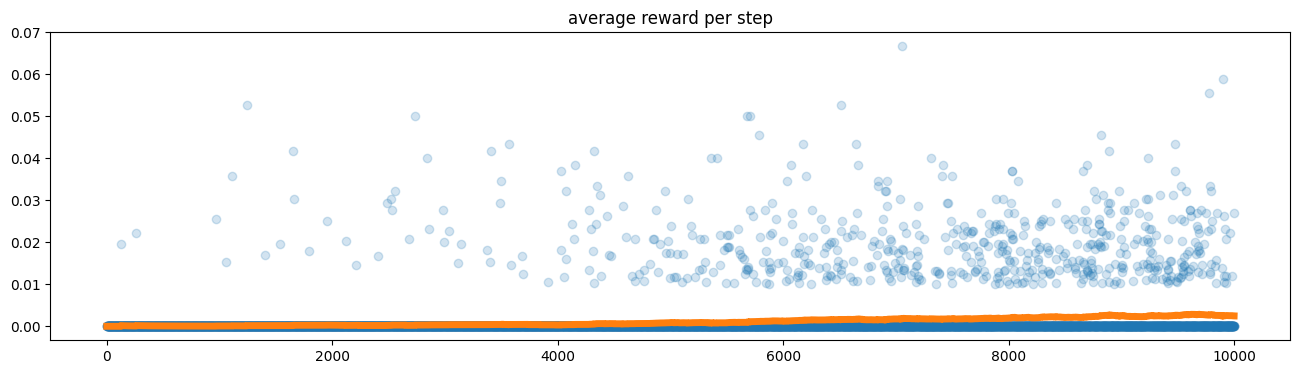

In [5]:
# Policy Eval
# Params
max_episode = 10000
video_path = os.path.join(ROOT, "video/sarsa.mp4")
random_seed = 101

# Initialize
history = []
total_reward = 0
report_interval = max_episode // 10
# set random seeds
rng = np.random.default_rng(random_seed)
np.random.seed(random_seed)
# epsilon decay
epsilon_schedule = create_decay_schedule(max_episode)
lr_schedule = create_decay_schedule(max_episode)

# Create Environment.
#env = gym.make('Taxi-v3')
# using render_mode=rgb_array so that video recording works
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8",
               is_slippery=True, render_mode='rgb_array')
env.np_random = rng

# Create Agent
agent = SarsaAgent(
    state_space=env.observation_space, 
    action_space=env.action_space, 
    discount_rate=0.9,
    epsilon=0.1,
    learning_rate=0.5
  )
# Start Learning
for i in range(max_episode):
    reward, steps = agent.play_episode(env, epsilon=epsilon_schedule[i])
    history.append(reward / steps)
    total_reward += reward
    if i % report_interval == 0 and i != 0:
        print(
            f"step: {i}, epsilon: {epsilon_schedule[i]}, total reward: {total_reward}, avarge success rate: {np.sum([x > 0 for x in history[-report_interval:-1]])/report_interval}, avarage reward per step: {np.mean(history[-report_interval:-1])}")
print(f"\nrewarding episodes: {total_reward}")

# For off policy learning only: get greedy policy (no exploration)
#agent._policy = get_epsilon_greedy_policy_from_action_values(agent._Q.weight)
# Run Eval
success_rate = estimate_success_rate(agent, env, 1000)
print(f"Success rate = {success_rate}")
# play last episode with video recording

plot_history(history)



In [7]:

reward, _ = agent.play_episode(env, learning=False, video_path=video_path)
html=render_mp4(video_path)
HTML(html)

Moviepy - Building video ../../video/sarsa.mp4.
Moviepy - Writing video ../../video/sarsa.mp4



Moviepy - Done !
Moviepy - video ready ../../video/sarsa.mp4


# Summary

## Temporal Difference on policy learning 
Temporal difference combines Monte Carlo with dynamic programming.
```
V(s) = V(s) + learning_rate * (reward + discount_rate * V(s') - V(s))
```
The last part is also called TD-error:
```
td_error = (reward + discount_rate * V(s') - V(s))
```

### Sarsa
Sarsa requires `(state, action, reward, next_state, next_action)` to update action_values `_Q` and use that to create a epsilon-greedy policy `_policy`.

What makes it on-policy learning is that fact that `next_action` is both 
1. the action the agent is taking  -> behavior policy
2. the action the agent is using to update the action values `_Q` (policy evluation) -> target policy

The conflict is that 1 requires exploration to learn from unexplored environment. But 2 is affected by such exploration (because next action will not always be the optimal one, affecting the value of `_Q`). 


